In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import time

In [31]:
PATH = '/content/gdrive/My Drive/X-ray ML/'

def load_data(dset='train'):
    labels = pd.read_csv(f'{PATH}target_{dset}.csv', index_col=0)
    X = []
    Y = []

    for im in labels.index.to_numpy():
        skipp = False
        try:
            x_o = Image.open(f'{PATH}images/{im}.png').convert('L')
        except:
            skipp=True
            print('skipp')

        if not skipp:
            width, height = x_o.size
            if width<height:
                border = int((height-width)/2)
                x_o = ImageOps.expand(x_o,border=border,fill='black')
                x_o = x_o.crop((0, border, width, height-border))
            else:
                cut = int((width-height)/2)
                x_o = x_o.crop((cut, 0, width-cut, height))

            x_ = np.asarray(x_o.resize((512, 512))) / 255
            X.append(x_)
            if dset=='train':
                y_ = labels.loc[im].to_numpy()[0]
            elif dset=='test':
                y_ = np.reshape(labels.loc[im].to_numpy(), 2)
            Y.append(y_)
    X, Y = np.array(X), np.array(Y)
    if dset=='train':
        X, Y = X[:, np.newaxis], Y[:, np.newaxis]
    elif dset=='test':
        X = X[:, np.newaxis]
    return X.astype(float), Y.astype(float)

class Xray_dataset(torch.utils.data.Dataset):

    def __init__(self, x, y):
        self.n_samples = x.shape[0]
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __getitem__(self, item):
        return self.x[item], self.y[item]

    def __len__(self):
        return self.n_samples

In [32]:
data = Xray_dataset(*load_data())

(223, 1, 512, 512) (223, 1)


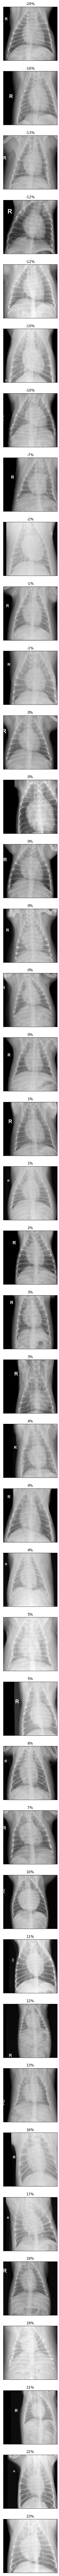

In [65]:
X_vis = []
Y_vis = []
for i in range(40):
    x, y = data[i]
    X_vis.append(x.numpy()[0].astype(float))
    Y_vis.append(y.numpy()[0].astype(float))

Y_vis, X_vis = zip(*sorted(zip(Y_vis, X_vis)))

fig = plt.figure(figsize=(4, 160))
for i in range(40):
    plt.subplot(40, 1, i+1)
    plt.imshow(X_vis[i], cmap='gray')
    plt.title(f'{int(Y_vis[i]*100)}%')
    plt.xticks([])
    plt.yticks([])
plt.savefig(f'{PATH}ordered.pdf', bbox_inches='tight')